# Finding Motion vectors

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
frame_1 = cv2.resize(cv2.imread("frame_484.png",0), (640, 640)) #first frame
frame_2 = cv2.resize(cv2.imread("frame_485.png",0), (640, 640)) #Second frame >> motion vectors are found for this frame

In [ ]:
plt.imshow(frame_1,cmap="gray")

In [ ]:
plt.imshow(frame_2,cmap="gray")

In [3]:
def sum_of_absolute_difference(image1,image2):
    diff = np.abs(image1 - image2)
    sad = np.sum(diff)
    return sad

def sum_of_absolute_difference_for_blocks(blocks_1,blocks_2):
    diff = np.abs(blocks_1 - blocks_2)
    sad = np.sum(diff)
    return sad



In [ ]:
# block = frame_50[120:250,265:340]
block = frame_50[230:410,250:350]
print(block.shape)
plt.imshow(block,cmap="gray")

# Searching for a simmilar block

Sequential search

In [4]:
def sequential_search(block,frame_100):
    block_height, block_width = block.shape  # Get block dimensions
    frame2_height,frame2_width = frame_100.shape
    min_sad = np.inf  # Initialize minimum SAD
    best_match_x = 0
    best_match_y = 0
    itter_2 = 0
    for y in range(0, frame2_height - block_height):
        for x in range(0, frame2_width - block_width):
            itter_2 = itter_2 + 1
            candidate_block = frame_100[y:y+block_height, x:x+block_width]

            # Calculate SAD between the block and candidate block
            sad = np.sum(np.abs(block - candidate_block))

            # Update best match if SAD is lower
            if sad < min_sad:
                min_sad = sad
                best_match_x = x
                best_match_y = y

    return best_match_x,best_match_y

# best_match_x,best_match_y = sequential_search(block,frame_100)

# best_match_sequential = frame_100[best_match_y:best_match_y+block_height,best_match_x:best_match_x+block_width]
# print(best_match_x,best_match_y,itter_2)
# plt.imshow(best_match_sequential,cmap="gray")

logarithmic search (Much faster but not that acurate)

In [5]:
import numpy as np

def logarithmic_search_2d(frame, block,curent_x,current_y):
    block_height, block_width = block.shape
    frame2_height, frame2_width = frame.shape

    if block_height > frame2_height or block_width > frame2_width:
        raise ValueError("Block dimensions exceed frame dimensions.")

    search_range = max(frame2_height, frame2_width) // 2
    # best_match_x, best_match_y = frame2_width // 2, frame2_height // 2
    best_match_x, best_match_y = curent_x,current_y
    min_sad = np.inf
    itter = 0
    while search_range >= 1:
        # Generate nine candidate positions in the current search window
        candidates = [(best_match_x + i * search_range, best_match_y + j * search_range)
                      for i in [-1, 0, 1] for j in [-1, 0, 1]]

        # Filter out candidates that exceed frame boundaries
        candidates = [(x, y) for x, y in candidates
                      if 0 <= x < frame2_width - block_width + 1 and 0 <= y < frame2_height - block_height + 1]

        for x, y in candidates:
            itter = itter + 1
            candidate_block = frame[y:y + block_height, x:x + block_width]
            sad = np.sum(np.abs(block - candidate_block))

            if sad < min_sad:
                min_sad = sad
                best_match_x, best_match_y = x, y

        # Update search range for the next iteration (reduce by half)
        search_range //= 2

    return best_match_x, best_match_y, min_sad,itter


# Obtaining motion vectors for all macro blocks

Dividing the second frame into macro blocks and finding the motion vectors for macro blocks

In [6]:
def get_blocks(frame):

    image_array = frame
    height, width = image_array.shape
    pad_height = (8 - height % 8) % 8
    pad_width = (8 - width % 8) % 8

    # Pad the image with zeros
    padded_image = np.pad(image_array, ((0, pad_height), (0, pad_width)), 'constant')

    # Calculate the number of blocks in each dimension
    num_blocks_h = padded_image.shape[0] // 8
    num_blocks_w = padded_image.shape[1] // 8

    blocks = np.empty((0, 8, 8))  # Initialize with the expected final shape

    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            start_x = j*8
            end_x = start_x + 8
            start_y = i*8
            end_y = start_y+8
            block = padded_image[start_x:end_x,start_y:end_y]
            blocks = np.concatenate((blocks, [block]), axis=0)
    return blocks

In [ ]:
from PIL import Image
image_array = frame_2
height, width = image_array.shape
pad_height = (8 - height % 8) % 8
pad_width = (8 - width % 8) % 8

# Pad the image with zeros
padded_image = np.pad(image_array, ((0, pad_height), (0, pad_width)), 'constant')

# Calculate the number of blocks in each dimension
num_blocks_h = padded_image.shape[0] // 8
num_blocks_w = padded_image.shape[1] // 8

blocks = np.empty((0, 8, 8))  # Initialize with the expected final shape
motion_vectors = []

for i in range(num_blocks_h):
    for j in range(num_blocks_w):
        start_x = j*8
        end_x = start_x + 8
        start_y = i*8
        end_y = start_y+8
        block = padded_image[start_x:end_x,start_y:end_y]
        blocks = np.concatenate((blocks, [block]), axis=0)
        block_height, block_width = block.shape
        
        #Check only close areas, Also find motion vectors if there is only a significant change in motion
        SAD = sum_of_absolute_difference(blocks_1[i],blocks_2[i])
        best_match_x, best_match_y, min_sad,itter = logarithmic_search_2d(frame_1, block,start_x,start_y)
        # best_match_x, best_match_y = sequential_search(block,frame_1)
        motion_vectors.append((best_match_x, best_match_y))
    #     if j > 2:
    #         break
    # if i > 2:
    #     break

In [7]:
from PIL import Image
image_array = frame_2
height, width = image_array.shape
pad_height = (8 - height % 8) % 8
pad_width = (8 - width % 8) % 8

# Pad the image with zeros
padded_image = np.pad(image_array, ((0, pad_height), (0, pad_width)), 'constant')

# Calculate the number of blocks in each dimension
num_blocks_h = padded_image.shape[0] // 8
num_blocks_w = padded_image.shape[1] // 8

blocks_1 = np.empty((0, 8, 8))
blocks_2 = np.empty((0, 8, 8))

motion_vectors = []
changed = []

for i in range(num_blocks_h):
    for j in range(num_blocks_w):
        start_x = j*8
        end_x = start_x + 8
        start_y = i*8
        end_y = start_y+8
        block_1 = frame_1[start_x:end_x,start_y:end_y]
        block_2 = frame_2[start_x:end_x,start_y:end_y]

        blocks_1 = np.concatenate((blocks_1, [block_1]), axis=0)
        blocks_2 = np.concatenate((blocks_2, [block_2]), axis=0)

        SAD = sum_of_absolute_difference(block_1,block_2)
        #check SAD
        if SAD > 5000:
            # best_match_x, best_match_y, min_sad,itter = logarithmic_search_2d(frame_1, block_2,start_x,start_y)
            best_match_x, best_match_y = sequential_search(block_2,frame_2[start_x-8:end_x+8,start_y-8:end_y+8])
            # best_match_x, best_match_y = start_x,start_y
            motion_vector = best_match_x, best_match_y,True
            changed.append((best_match_x, best_match_y))
        else:
            best_match_x, best_match_y = start_x,start_y
            motion_vector = best_match_x, best_match_y,False
        motion_vectors.append(motion_vector)

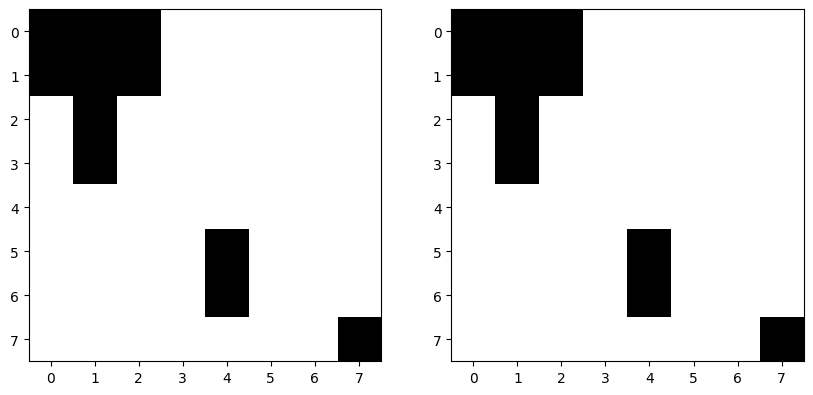

In [24]:
num = 28
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize as needed
best_match_log = frame_1[motion_vectors[num][0]:motion_vectors[num][0]+8,motion_vectors[num][1]:motion_vectors[num][1]+8]
ax1.imshow(blocks_2[num], cmap="gray")
ax2.imshow(best_match_log, cmap="gray")

412


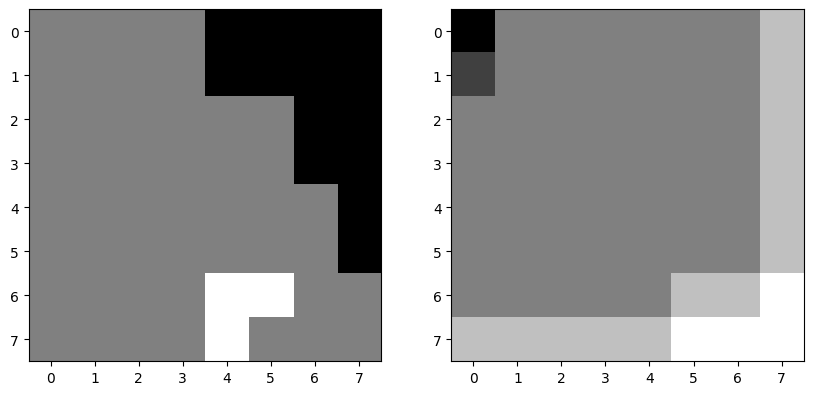

In [25]:
num = 50
print(len(changed))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize as needed
best_match_log = frame_1[changed[num][0]:changed[num][0]+8,changed[num][1]:changed[num][1]+8]
ax1.imshow(blocks_2[num], cmap="gray")
ax2.imshow(best_match_log, cmap="gray")

# Creating the Predicted current frame

In [8]:
blocks = np.empty((0, 8, 8))
for motion_vector in motion_vectors:
    if motion_vector[2]:
        block = frame_1[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        blocks = np.concatenate((blocks, [block]), axis=0)
    else:
        block = frame_2[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        blocks = np.concatenate((blocks, [block]), axis=0)
print(blocks.shape)

(6400, 8, 8)


In [9]:
def reconstruct_from_blocks(blocks):
    reconstructed = np.zeros(padded_image.shape)

    block_number = 0
    for i in range(80):
        for j in range(80):
            start_x = j*8
            end_x = start_x + 8
            start_y = i*8
            end_y = start_y+8
            reconstructed[start_x:end_x,start_y:end_y] = blocks[block_number]
            block_number = block_number + 1
    
    return reconstructed

In [10]:
index_list = []
for index,block in enumerate(blocks):
    SAD = sum_of_absolute_difference(block,blocks_1[index])
    if SAD>0:
        index_list.append(index)

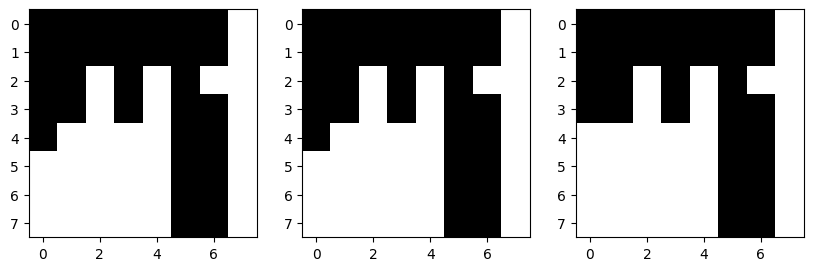

In [23]:
inex = index_list[74]
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 6))  # Adjust figsize as needed
ax1.imshow(frame_1[motion_vectors[inex][0]:motion_vectors[inex][0]+8,motion_vectors[inex][1]:motion_vectors[inex][1]+8], cmap="gray")
ax2.imshow(blocks_1[inex], cmap="gray")
ax3.imshow(blocks_2[inex], cmap="gray")
# ax4.imshow(blocks[inex], cmap="gray")

In [11]:
reconstructed = reconstruct_from_blocks(blocks)

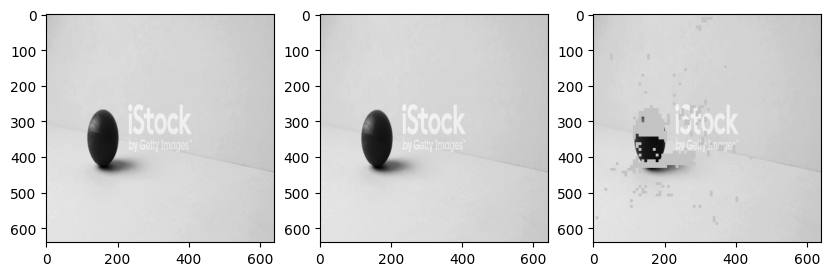

In [12]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 6))  # Adjust figsize as needed
ax1.imshow(frame_1, cmap="gray")
ax2.imshow(frame_2, cmap="gray")
ax3.imshow(reconstructed, cmap="gray")

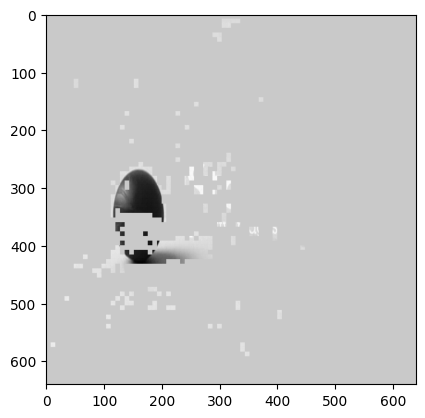

In [18]:
# residual = reconstructed - frame_2
residual = frame_2 - reconstructed
plt.imshow(residual,cmap='gray')

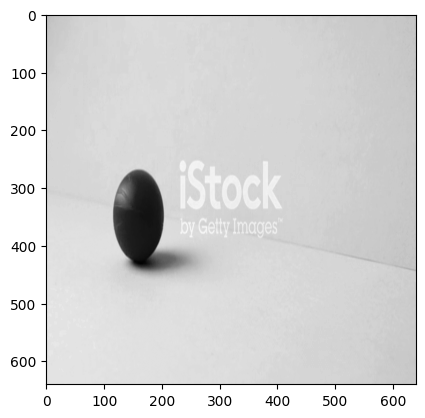

In [14]:
result = reconstructed - residual
plt.imshow(result,cmap='gray')